## Random Forest Regerssor and Result Analysis
- 목적
    - RandomForest API 활용
    - 모델의 예측값 분석

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json
from ipywidgets import interact

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nyc-taxi-demand-predict' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

In [2]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [3]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

Downloading: 100%|██████████████████████████████████████████████████████████| 87020/87020 [00:08<00:00, 10781.88rows/s]

Wall time: 20.5 s


### 데이터 전처리
- One Hot Encoding이 아닌 Label Encoding

In [4]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [5]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [6]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [7]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_le
65113,11415,2015-01-23 23:00:00,1,23,4,23,0,1,258
65114,10040,2015-01-23 23:00:00,1,23,4,23,0,2,37
65115,10271,2015-01-23 23:00:00,1,23,4,23,0,1,64
65116,11204,2015-01-23 23:00:00,1,23,4,23,0,1,193
65117,11356,2015-01-23 23:00:00,1,23,4,23,0,1,231


- 사용하지 않을 컬럼 삭제

In [8]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [9]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,zip_code_le
0,1,1,3,0,0,26,34
1,1,1,3,0,0,44,57


In [10]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [11]:
x_train = train_df.copy()
x_test = test_df.copy()

### 모델링

In [12]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [15]:
@ex.config
def config():
    n_estimators=100
    n_jobs=-1

In [16]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [17]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [19]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "6"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 183.2823460924415}, 'mae': {'score': 34.738904209661214}, 'mse': {'score': 12018.972510766138}}
INFO - nyc-demand-prediction - Completed after 0:00:13


In [20]:
experiment_result.config

{'n_estimators': 100, 'n_jobs': -1, 'seed': 740308478}

In [21]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    with open(f'./experiments/{ex_id}/run.json') as run_file:
        run_data = json.load(run_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    run_df = pd.DataFrame(run_data['result'])
    output_df = pd.concat([output_df, run_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [22]:
parsing_output(6)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,6,"{'n_estimators': 100, 'n_jobs': -1, 'seed': 74...",34.74,183.28,12018.97


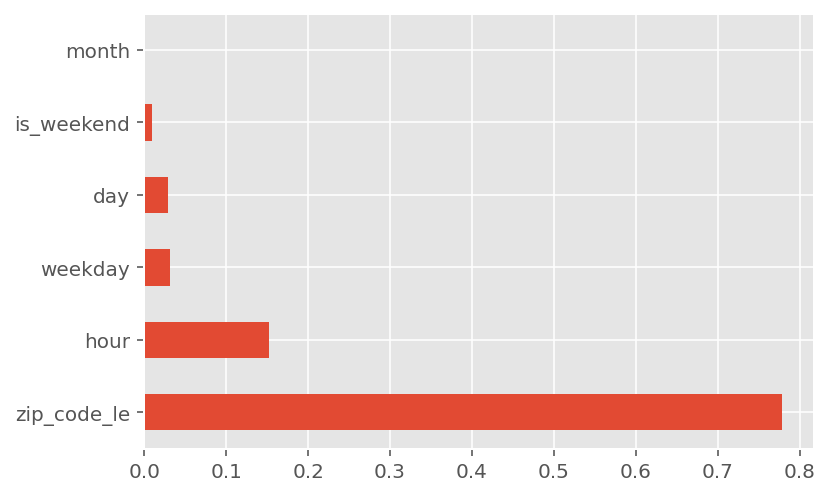

In [26]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

### 결과 분석
- 어떤 알고리즘이 제일 성능이 좋았는지?
- RandomForest의 mae : 35, mape : 183, mse : 12019
- test값과 pred 값이 전체적으로 어떠한지?

In [27]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.68,538.52,16512.33


In [28]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,5,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.99,410.7,13871.77


In [29]:
parsing_output(6)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,6,"{'n_estimators': 100, 'n_jobs': -1, 'seed': 74...",34.74,183.28,12018.97


In [30]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,245
65119,1,24,5,0,1,206
65120,1,24,5,0,1,68
65121,1,24,5,0,1,67
65122,1,24,5,0,1,80


### Data 복구
- Label Encoding, 삭제한 데이터, Datetime 등 다시 reverse encoding

In [31]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred

In [32]:
test_df['year'] = 2015

In [33]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year
87015,1,31,5,23,1,249,2,5.85,2015
87016,1,31,5,23,1,56,2,3.48,2015
87017,1,31,5,23,1,96,1,1.54,2015
87018,1,31,5,23,1,235,1,1.21,2015
87019,1,31,5,23,1,88,1,1.23,2015


In [34]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

INFO - numexpr.utils - NumExpr defaulting to 4 threads.


In [35]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime
87015,1,31,5,23,1,249,2,5.85,2015,2015-01-31 23:00:00
87016,1,31,5,23,1,56,2,3.48,2015,2015-01-31 23:00:00
87017,1,31,5,23,1,96,1,1.54,2015,2015-01-31 23:00:00
87018,1,31,5,23,1,235,1,1.21,2015,2015-01-31 23:00:00
87019,1,31,5,23,1,88,1,1.23,2015,2015-01-31 23:00:00


In [36]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [37]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime,zip_code
87015,1,31,5,23,1,249,2,5.85,2015,2015-01-31 23:00:00,11375
87016,1,31,5,23,1,56,2,3.48,2015,2015-01-31 23:00:00,10169
87017,1,31,5,23,1,96,1,1.54,2015,2015-01-31 23:00:00,10467
87018,1,31,5,23,1,235,1,1.21,2015,2015-01-31 23:00:00,11361
87019,1,31,5,23,1,88,1,1.23,2015,2015-01-31 23:00:00,10459


In [38]:
test_df = test_df.set_index('datetime')

### Datetime별 차이

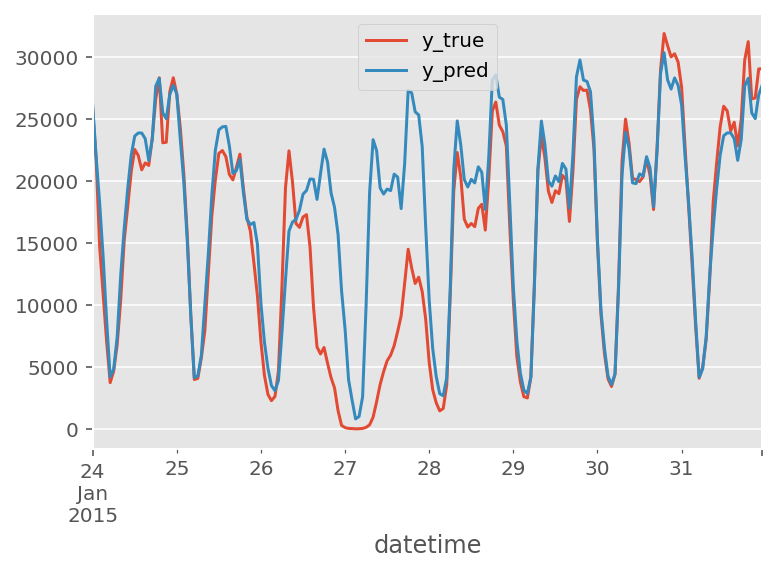

In [39]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

### Zip Code별 차이

In [42]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [43]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Hour별 차이

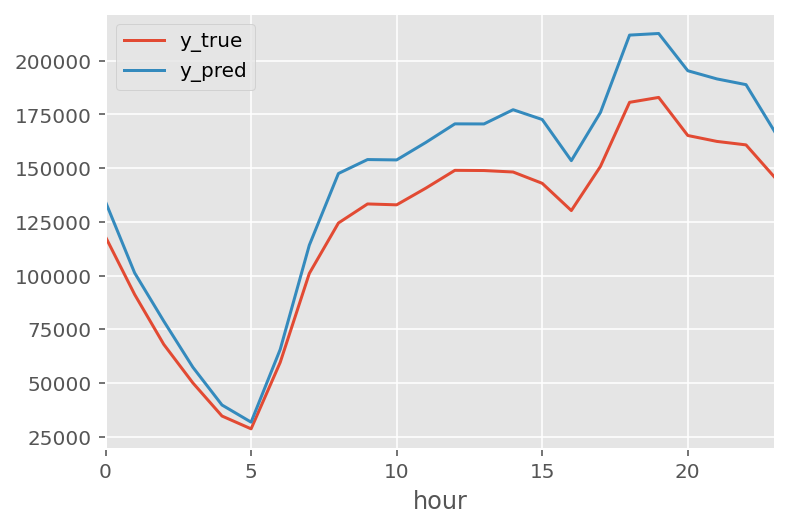

In [45]:
test_df[['hour','y_true','y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

In [46]:
test_df[['hour','y_true','y_pred']].groupby('hour').sum()[['y_true', 'y_pred']]

,y_true,y_pred
hour,,
0,118017,134319.05
1,91196,101240.72
2,67973,78789.31
3,50021,57317.71
4,34603,39738.88
5,28638,31753.38
6,59575,65600.99
7,100996,114149.60
8,124475,147523.81


- 새벽 시간엔 거의 유사하다가 7시부터 20시까지 계속 차이가 남

### Weekday별 차이

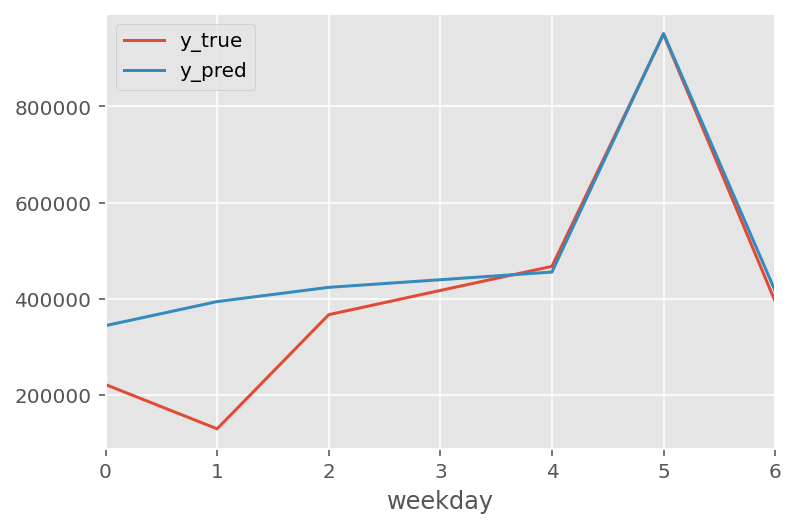

In [47]:
test_df[['weekday','y_true','y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

### 평일/주말별 차이

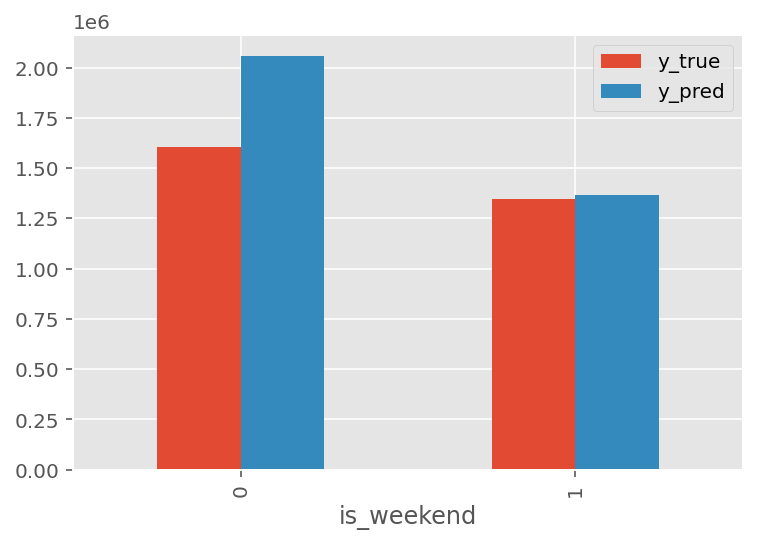

In [48]:
test_df[['is_weekend','y_true','y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');

- 평일에 못맞추는 편, 주말에 잘 맞추는 편
    - 평일 중 특히 월화에 격차가 있음